## **The Simplest Graph**
![Screenshot 2024-08-20 at 3.11.22 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png)

In [10]:
import warnings
warnings.filterwarnings("ignore")

from typing_extensions import TypedDict
import random
from langgraph.graph import StateGraph, END
from IPython.display import display, Image

### **State**
The [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) schema serves as the input schema for all Nodes and Edges in the graph.

In [5]:
class State(TypedDict):
    message: str

### **Node**
[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are python functions.

Because the state is a `TypedDict` with schema as defined above, each node can access the key, `message`, with `state['message']`.

Each node returns a new value of the state key `message`.
  
By default, the new value returned by each node [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value.

In [ ]:
def node_1(state: State) -> State:
    print ("--- Node 1 ---")
    return {"message": "I am"}

def node_2(state):
    print ("--- Node 2 ---")
    return {"message": state["message"] + " happy."}

def node_3(state):
    print ("--- Node 3 ---")
    return {"message": state["message"] + " sad."}

### **Edges**

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) connect the nodes.

Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.

[Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) are used if you want to *optionally* route between nodes.
 
Conditional edges are implemented as functions that return the next node to visit based upon some logic.

In [7]:
def moodDecide (state):
    return "node_2" if random.random() > 0.5 else "node_3" 

### **Graph Construction**

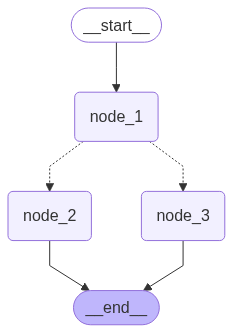

In [11]:
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.set_entry_point("node_1")
builder.add_conditional_edges(
    "node_1",
    moodDecide,
    {
        "node_2": "node_2",
        "node_3": "node_3"
    }
)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### **Graph Invocation**
The compiled graph follows the [Runnable](https://python.langchain.com/docs/concepts/runnables/) protocol, allowing execution via the `invoke` method.

We pass an initial state `{"graph_state": "Hi, this is Khoa."}` to start execution at the `START` node. 

The graph moves through nodes (`node_1`, `node_2`/`node_3`) based on the `moodDecide` function. 

Each node updates the state, and execution ends at the `END` node.

In [14]:
graph.invoke({"message": "Hi, this is Khoa."})

--- Node 1 ---
--- Node 2 ---


{'message': 'I am happy'}

## **Chain**
![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [27]:
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv, find_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage, AnyMessage
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

### **Messages**

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [37]:
messages = [
    SystemMessage(content="You are a helpful assistant.", name = "system"),
    HumanMessage(content = "Hello, my name is Khoa.", name = "userKhoa")
]
messages.append(AIMessage(content = "Hi Khoa, I am an AI assistant.", name = "assistant"))

for m in messages:
    print (m)

content='You are a helpful assistant.' additional_kwargs={} response_metadata={} name='system'
content='Hello, my name is Khoa.' additional_kwargs={} response_metadata={} name='userKhoa'
content='Hi Khoa, I am an AI assistant.' additional_kwargs={} response_metadata={} name='assistant'


### **Chat Models**

In [18]:
_ = load_dotenv(find_dotenv())
chat = ChatOpenAI(
    model = 'gpt-3.5-turbo',
    temperature = 0
)

### **Tools**

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 
 
You can pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

In [23]:
def multiply(a: float, b: float) -> float:
    """
    Multiply a and b.

    Args:
        a (float): First number.
        b (float): Second number.
    """
    return a * b
llm_with_tools = chat.bind_tools([multiply])

response = llm_with_tools.invoke([
    HumanMessage(content = "What is the product of 2 and 3?")
])
response.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_zTq07uwRWOBZ6SchbEhMCnt0',
  'type': 'tool_call'}]

### **Reducers**

In [25]:
class State(TypedDict):
    messages: list[AnyMessage] # Any type of message is acceptable including FunctionMessage, ToolMessage, etc.

By default, each node’s output overwrites the `messages` state.

To append messages instead, we use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers), which control how state updates are handled.

For `messages`, we apply the pre-built `add_messages` reducer to ensure new messages are added to the existing list.

Simply annotate the `messages` key with this reducer in the state metadata.

In [29]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [38]:
text = HumanMessage(content = "This is a new message.")
add_messages(messages, text)

[SystemMessage(content='You are a helpful assistant.', additional_kwargs={}, response_metadata={}, name='system', id='1b4fbfe8-530b-4154-a004-2df676c683db'),
 HumanMessage(content='Hello, my name is Khoa.', additional_kwargs={}, response_metadata={}, name='userKhoa', id='bd739b45-f87c-4368-981a-11cc6da6d40b'),
 AIMessage(content='Hi Khoa, I am an AI assistant.', additional_kwargs={}, response_metadata={}, name='assistant', id='91bc3760-e0a9-471e-bbeb-5fbb87b4e5ac'),
 HumanMessage(content='This is a new message.', additional_kwargs={}, response_metadata={}, id='e13aa932-bba0-4f03-853a-e9b831fa4e0f')]

### **Graph Construction**

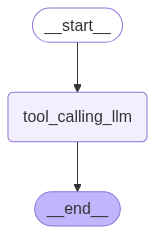

In [41]:
def tool_calling_llm(state):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)

builder.set_entry_point("tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from pprint import pprint

response = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_O5HRSsV6vyT26oJQB9Xoxiq5)
 Call ID: call_O5HRSsV6vyT26oJQB9Xoxiq5
  Args:
    a: 2
    b: 3


## **Router**
![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv, find_dotenv
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage, HumanMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition


_ = load_dotenv(find_dotenv())
chat = ChatOpenAI(
    model = 'gpt-3.5-turbo',
    temperature = 0
)

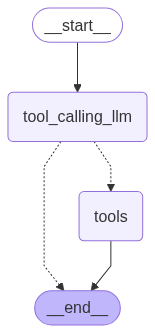

In [ ]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


def tool_calling_llm(state):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

def multiply(a: float, b: float) -> float:
    """
    Multiply a and b.

    Args:
        a (float): First number.
        b (float): Second number.
    """
    return a * b
llm_with_tools = chat.bind_tools([multiply])


builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))

builder.set_entry_point("tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message from assistant is a tool call       -> tools_condition routes to tools
    # If the latest message from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [58]:
from pprint import pprint

response = graph.invoke({"messages": [HumanMessage(content = "Multiply 2 and 3.")]})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_S04rWvUZKeGsfsPlkFFW1nmj)
 Call ID: call_S04rWvUZKeGsfsPlkFFW1nmj
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6.0
